### Проект: mobile gaming <h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import requests 
from urllib.parse import urlencode

import scipy.stats as stats
import pingouin as pg
import seaborn as sns

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


##### Задача: расчет retention rate<h5>
Мы будем исследовать нескольких аспектов мобильного приложения.

В первую очередь, составим функцию для подсчета __retention__ (по дням от даты регистрации игрока).

In [2]:
reg_date = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-fefilova/shared/problem1-reg_data.csv', 
                       sep=';')

In [3]:
reg_date.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


В датасете __reg_date__ имеются следующие данные:
- __reg_ts__ - время регистрации в формате timestamp
- __uid__ - id пользователя

In [4]:
reg_date.shape

(1000000, 2)

In [5]:
reg_date.uid.nunique()  # проверим все ли user id в данных с регистрацией пользователей уникальны

1000000

Все данные о регистрациях уникальны, а также их количество совпадает с общим количеством строк в этом датасете, а значит, пропущенных значений нет.

In [6]:
auth_date = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-fefilova/shared/problem1-auth_data.csv', 
                        sep=';')

In [7]:
auth_date.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


В датасете __auth_date__ имеются следующие данные:
- __auth_ts__ - время входа пользователя в игру в формате timestamp
- __uid__ - id пользователя

In [8]:
auth_date.shape

(9601013, 2)

In [9]:
auth_date.isna().sum()  # проверим нет ли пропущенных значений

auth_ts    0
uid        0
dtype: int64

__Функция, которая будет считать retention игроков (по дням от даты регистрации игрока):__

In [10]:
def n_days_retention(reg, auth, start, end):
    
    '''
    n_days_retention(reg, auth, start, end), где reg и auth - это датасеты, 
    содержащие данные о регистрациях и авторизациях юзеров соответственно, 
    а start и end - даты (в формате "YYYY-MM-DD") начала и окончания периода, 
    по которому будет идти расчет n-day retention.
    
    Данная функция рассчитывает retention (отношение числа игроков,
    которые вернулись в игру повторно в каждый день выбранного периода, 
    к числу игроков на начало расчетного периода). 
    '''
    
# Скопируем датафреймы, чтобы функция не меняла исходные данные    
    reg2 = reg.copy()
    auth2 = auth.copy()

# Поменяем unix timestamp в human-readable формат, преобразуем в дни и переименуем колонки
    reg2['reg_ts'] = pd.to_datetime(reg2.reg_ts, unit='s').dt.to_period('D')
    reg2 = reg2.rename(columns={"reg_ts": "registration"})
    
    auth2['auth_ts'] = pd.to_datetime(auth2.auth_ts, unit='s').dt.to_period('D')
    auth2 = auth2.rename(columns={"auth_ts": "authorization"})
    
# Отберем данные только за нужный период
    df_reg = reg2.query('registration >= @start and registration <= @end')
    df_auth = auth2.query('authorization >= @start and authorization <= @end')
    
# Объединим два датасета в один
    df_auth_reg = df_auth.merge(df_reg, how='left', on='uid')
    
# В получившимся датасете есть авторизации юзеров, зарегистрировавшихся до начала нужного нам перода.
# Уберем эти авторизации из исследуемых данных.
    df_cleared = df_auth_reg.dropna(axis=0, how='any')

# Посчитаем разницу в днях между регистрацией и аутентификацией и преобразуем результат в целое число
    df_cleared['days'] = df_cleared.authorization - df_cleared.registration
    df_cleared['days'] = df_cleared.days.apply(lambda x: x.n)
    
# Сгруппируем когорты
    df_cohorts = df_cleared\
        .groupby(['registration', 'days'], as_index=False)\
        .nunique('uid')\
        .rename(columns={"uid": "user_count"})

# Создадим сводную таблицу
    pivot_df = df_cohorts.pivot(index='registration', columns='days', values='user_count')
    
# Рассчитаем retention
    users_retention = pivot_df.divide(pivot_df[0], axis=0)

# Добавим столбец с данными о размере каждой когорты
    users_retention.insert(0, "cohort_size", pivot_df[0], False)
    
# Удалим неинформативный столбец за 0 день
    del users_retention[users_retention.columns[1]]
    
# Оформим визуализацию получившейся таблицы
    ur_style = (users_retention
                .style
                .set_caption('User retention')  # добавляем подпись
                .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
                .highlight_null('white')  # делаем белый фон для значений NaN
                .format("{:.2%}", na_rep="")  # числа форматируем как проценты, NaN заменяем на пустоту
                .format(formatter={('cohort_size'): "{:.0f}"}))  # столбец с размерами когорт форматируем как числа

    return ur_style

Проверим функцию на сэмпле данных:

In [11]:
auth_sample = auth_date.sample(500000, random_state=1)

In [12]:
user_retention = n_days_retention(reg_date, auth_sample, "2020-03-01", "2020-03-08")
user_retention

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


days,cohort_size,1,2,3,4,5,6,7
registration,,,,,,,,
2020-03-01,61,,3.28%,4.92%,4.92%,4.92%,6.56%,1.64%
2020-03-02,54,1.85%,,5.56%,14.81%,9.26%,,
2020-03-03,59,1.69%,,1.69%,5.08%,6.78%,,
2020-03-04,75,1.33%,,4.00%,4.00%,,,
2020-03-05,55,7.27%,9.09%,10.91%,,,,
2020-03-06,60,1.67%,3.33%,,,,,
2020-03-07,78,2.56%,,,,,,
2020-03-08,53,,,,,,,


##### Задача: анализ результатов A/B теста <h5>
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

_Загрузим данные с Яндекс диска_

In [13]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в датафрейм df_exe_3
download_response = requests.get(download_url) 
df_exe_2 = pd.read_csv(download_url, sep=';')

In [14]:
df_exe_2.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [15]:
df_exe_2.shape

(404770, 3)

In [16]:
df_exe_2.isna().sum()  # проверим нет ли пропущенных значений

user_id      0
revenue      0
testgroup    0
dtype: int64

In [17]:
df_exe_2.nunique()  # узнаем количество уникальных значений

user_id      404770
revenue        1477
testgroup         2
dtype: int64

Посмотрим на группы в отдельности:

In [18]:
df_exe_2.testgroup.value_counts()  # узнаем сколько пользователей в каждой группе

b    202667
a    202103
Name: testgroup, dtype: int64

В группах примерно одинаковое количество игроков.

Сделаем график распределения выручки в группе a и b, предварительно убрав нулевые значения выручки:

[Text(0, 0.5, 'Paying user count'),
 Text(0.5, 0, 'Revenue'),
 Text(0.5, 1.0, 'Revenue distribution between AB-test groups')]

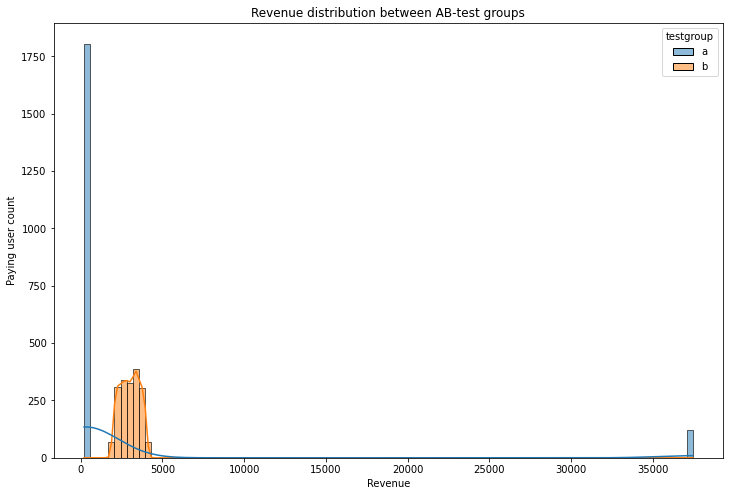

In [19]:
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=df_exe_2.query('revenue > 0'), 
                  x='revenue', 
                  hue='testgroup', 
                  kde=True, 
                  bins=100)
ax.set(xlabel='Revenue',
       ylabel='Paying user count',
       title='Revenue distribution between AB-test groups')

Из графика видно, что распределение пользователей в группах значительно отличается. В контрольную группу попали игроки с низким чеком, а также с очень высоким чеком (> 35 000), в то время как в тестовой группе  пользователи не платили больше 5 000. 
Сплитование осуществлено некорректно. 

Несмотря на это, посмотрим данные дальше.


Узнаем общую выручку по группам:

In [20]:
df_exe_2.groupby(['testgroup'], as_index=False) \
        .agg({'revenue': 'sum'}) \
        .rename(columns={"revenue": "total_revenue"})

,testgroup,total_revenue
0,a,5136189
1,b,5421603


В тестовой группе общая выручка была выше, но делать вывод о выборе тестового набора акционных предложений пока рано.

_Посмотрим на общее количество платящих и не платящих пользователей в каждой группе_

Добавим в исходный датафрейм столбец cr, со значением 1, если игрок осуществил покупку, и со значением 0, если покупки не было.

In [21]:
df_exe_2['cr'] = df_exe_2.revenue.apply(lambda x: 0 if x == 0 else 1)
df_exe_2.tail(5)

,user_id,revenue,testgroup,cr
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0
404769,404770,0,b,0


In [22]:
df_exe_2.groupby(['cr', 'testgroup'], as_index=False) \
        .agg({'user_id': 'count'}) \
        .rename(columns={"user_id": "user_count"}) \
        .pivot(index='testgroup', columns='cr', values='user_count') \
        .rename(columns={0: "not_paying_users", 1: "paying_users"})

cr,not_paying_users,paying_users
testgroup,,
a,200175,1928
b,200862,1805


В контрольной группе платящих пользователей больше.

Узнаем минимальный и максимальный чек пользователей в каждой группе:

In [23]:
df_exe_2.query('revenue > 0') \
        .groupby(['testgroup'], as_index=False) \
        .agg({'revenue': 'min'}) \
        .rename(columns={"revenue": "min_revenue_per_paying_user"})

,testgroup,min_revenue_per_paying_user
0,a,200
1,b,2000


In [24]:
df_exe_2.query('revenue > 0') \
        .groupby(['testgroup'], as_index=False) \
        .agg({'revenue': 'max'}) \
        .rename(columns={"revenue": "max_revenue_per_user"})

,testgroup,max_revenue_per_user
0,a,37433
1,b,4000


Несмотря на то, что в тестовой группе выручка (5 421 603) была выше, чем в контрольной (5 136 189), мы не можем сделать однозначного вывода о том, что тестовый набор акционных предложений предпочтительнее.

Кроме того, в контрольной группе максимальный чек (37 433) больше, чем в 9 раз выше, чем в тестовой (4 000). Еще раз возникает мысль о некорректном сплитовании.

Исследуем данные дальше.

__Исходя из имеющихся у нас данных посмотрим следующие метрики:__
- ARPU - средняя выручка на одного пользователя
- ARPPU - средняя выручка на одного платящего пользователя
- CR - конверсию в покупку

In [25]:
def metrics(a, b):
    '''
    функция metrics на вход принимает два датафрейма с данными о том какую выручку принес каждый из игроков
    в каждой группе, и выводит значения метрик ARPU, ARPPU и CR
    '''
    
#   ARPU
    arpu_a = (a.revenue.sum() / a.user_id.nunique())
    arpu_b = (b.revenue.sum() / b.user_id.nunique())

#   ARPPU
    arppu_a = (a.revenue.sum() / a.query('revenue > 0').user_id.nunique())
    arppu_b = (b.revenue.sum() / b.query('revenue > 0').user_id.nunique())
    
#   CR
    cr_a = a.query('revenue > 0').user_id.nunique() / a.user_id.nunique()
    cr_b = b.query('revenue > 0').user_id.nunique() / b.user_id.nunique()
    
#   Создадим словарь, из которого получится датафрейм с искомыми метриками
    total = {'arpu': [arpu_a, arpu_b],
             'arppu': [arppu_a, arppu_b],
             'cr': [cr_a, cr_b]}  
    
#   Присвоим значения a и b индексам датафрейма            
    total = pd.DataFrame(total, index=['a', 'b'])
    
    return total

In [26]:
group_a = df_exe_2.query('testgroup == "a"')  # данные контрольной группы

group_b = df_exe_2.query('testgroup == "b"')  # данные тестовой группы

In [27]:
metrics_ab = metrics(group_a, group_b)
metrics_in_style = (metrics_ab
                    .style
                    .set_caption('Key metrics of AB-test')  # добавляем подпись
                    .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам (желтый - больше)
                    .format(formatter={('arpu', 'arppu'): "{:.2f}",
                                       ('cr'): "{:.2%}"}))  # числа в столбце cr форматируем как проценты
metrics_in_style

,arpu,arppu,cr
a,25.413720,2663.998444,0.95%
b,26.751287,3003.658172,0.89%


Мы видим, что ARPU и ARPPU в тестовой группе выше, в то время как конверсия в покупку выше в контрольной группе.

__Итак, какой все же набор предложений можно считать лучшим?__

__ARPU__

Из графика распределения выручки в группе a и b было видно, что распределения не являются нормальными.

На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов.
Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Левена.

Что касается выбросов - проведем тест дважды: на полных данных и на данных контрольной группы без выбросов (самых высоких чеков).

Гипотезы:

- H0 – в генеральной совокупности никакого различия между средними значениями нет

- H1 – средние в генеральной совокупности не равны (альтернативная гипотеза)

In [28]:
pg.homoscedasticity(data=df_exe_2, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


Дисперсии гомогенны, значит можем применить t-test

In [29]:
stats.ttest_ind(group_a.revenue, group_b.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

p-value > 0.05, значит отклонить H0 мы не можем, то есть по результатам этого теста статистически значимых различий ARPU контрольной и тестовой групп нет.

Сделаем еще одну проверку на данных без выбросов (хоть я и считаю неправильным игнорировать в исследовании игроков, приносящих максимальную выручку, но все равно решила посмотреть на результат, узнать будут ли отличия)

In [30]:
df_exe_2_clean = df_exe_2.query("revenue < 35000")
group_a_clean = group_a.query("revenue < 35000")

In [31]:
pg.homoscedasticity(data=df_exe_2_clean, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,1400.723139,4.912188e-306,False


Дисперсии не гомогенны, поэтому используем t-критерий Уэлча

In [32]:
stats.ttest_ind(group_a_clean.revenue, group_b.revenue, equal_var=False)

Ttest_indResult(statistic=-37.48854905417036, pvalue=1.529802212310516e-306)

В этом случае также p-value > 0.05, значит отклонить H0 мы не можем, то есть по результатам этого теста статистически значимых различий ARPU контрольной и тестовой групп нет.

__ARPPU__

Из графика распределения выручки в группе a и b было видно, что распределения не являются нормальными. Проверим гомогенность дисперсий с помощью критерия Левена

Гипотезы:

- H0 – в генеральной совокупности никакого различия между средними значениями нет

- H1 – средние в генеральной совокупности не равны (альтернативная гипотеза)

In [33]:
pg.homoscedasticity(data=df_exe_2.query("revenue > 0"), dv="revenue", group="testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


Дисперсии не гомогенны, поэтому используем t-критерий Уэлча

In [34]:
stats.ttest_ind(group_a.query("revenue > 0").revenue, group_b.query("revenue > 0").revenue, 
                equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

p-value > 0.05, значит отклонить H0 мы не можем, то есть по результатам этого теста статистически значимых различий ARPPU контрольной и тестовой групп нет.

__CR__

Теперь прверим различия CR при помощи Хи-квадрат.

Гипотезы:

- H0 – различий между тестовой и контрольной группами нет

- H1 – различия между контрольной и тестовой группами есть

In [35]:
stats.chi2_contingency(pd.crosstab(df_exe_2.testgroup, df_exe_2.cr))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

Так как p-value < 0.05, отклоняем H0. Различия между группами статистически значимы

__Вывод:__ 

Тестовый набор предложений внедрять, на мой взгляд, не стоит. Нет достоверных данных о том, что он увеличивает целевые метрики.
Хотя тестовая группа показала большую общую выручку, чем контрольная (5 421 603 vs 5 136 189). По проведенным статистическим тестам, мы видим, что ARPU и ARPPU статистически не различаются в контрольной и тестовой группах, в то время как различия в CR статистически значимы (а конверсия была выше в контрольной группе - 0.95% vs 0.89% в тестовой группе).

Таким образом, я бы рекомендовала оставить акционный набор предложений, который применяли в контрольной группе, скорректировать сплитование и провести новый эксперимент. 

Кроме того, вероятно, есть смысл в том, чтобы выделить различные группы пользователей по объему выручки (0, низкий чек, средний чек, высокий чек), и экспериментировать с тем, что будет наиболее действенным для каждой из этих групп. 

##### Задача: подбор метрик для оценки результатов тематического события в игре <h5>
_В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?_

Мобильная игра, тест последнего тематического события.
- __Целевые__: 
 - daily active users (DAU), чтобы отслеживать как меняется количество пользователей в день в зависимости от события
 - monthly active users (MAU), чтобы сравнить событие этого месяца с предыдущими (возможно оно привлекло новых пользователей, или кто-то из давно не заходивших вернулся)
 - липкость (Stickiness = DAU / MAU) — насколько часто пользователи заходят в игру (когда событие есть/когда его нет/по сравнению с прошедшими событиями)
 - Average revenue per daily active user (ARPDAU) = Daily revenue/DAU. Средняя выручка на активного пользователя.
 - ARPPU - средний доход на платящего пользователя
 - Если в игре есть разные пути монетизации, например - платная подписка, внутриигровые покупки, то их отслеживать дополнительно.
 - Установки приложения.
 - LTV
 
- __Опережающие__: 
 - retention rate - отношение игроков, которые вернулись в игру повторно, к числу пользователей на начало расчетного периода. Насколько хорошо получается удерживать игроков.
 - churn rate - насколько пользователи отваливаются (из-за багов, ошибок, кривых механик и т.д.)
 - частота обращений в службу поддержки
 - внутриигровые покупки за монеты и бонусы
- __Guardrail__: 
 - продолжительность игровой сессии
 - количество игровых сессий в день/за период тематического события
 - количество уровней, успешно пройденных игроком за заданное время


_Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?_

Да, я бы добавила еще guardrail метрики:
- количество неудачных попыток выполнения уровня на каждого игрока
- на сколько уровней откатывались игроки
- после откатов как часто бросали проходить тематическое событие
